<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/deep_learning_fundamentals/self_attention_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding the attention mechanism

The idea of this small project is to show how the attention mechanism works at a small scale. Attention is this cool feature that was first introduced in 2015 for Recurrent Neural Networks (RNNs), and that is the base building block of the Transformer arquitecture.

First, we will take a look into BERT the original encoder model published by Google in 2018. And we will see how the attention block of the transformer is built. We will notice that it's just a simple attention block, similar to the one discussed in the famous [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) paper.

We need to install the **transformers** library from HuggingFace in order to do so, so simply run the command below:

In [1]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.9 MB/s eta 0:00:00


In [2]:
import torch

## Understanding Attention in BERT's first layer

Below we will just import the BERT uncased model from HuggingFace. Let's explore how the model's layers are built. The BERT base uncased model is a pre-trained model from Google that can be used for feature extraction. It converts de prompt we pass to the model to a

In [38]:
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


As seen below, BERT has 12 attention layers in the enconder phase in total. Each of this attention layers can be though of as a creating a deeper and more context-aware representation of the input, based on the raw values of the input as individual tokens.

In [5]:
len(model.encoder.layer)

12

The attention mechanism breaks the initial input into 3 matrices Q, K and V. These 3 matrices are used to generate a representation of how much "attention" should be payed to each of the input tokens, based on the embeddings for each token on its own.

In [6]:
model.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

### Example of the Q, K and V matrices given an input

Let's create an input phrase, for example: "I am short". Now let's create the corresponding spaces Q, K and V for this tokens, and see how that would play out. The input has 3 words (and we will treat words like tokens for now), so we will have our input "X" be 3 x 9 where 9 is just our vocabulary, our "number of possible words", if you will.

**Note:** In reality, words will actually be tokens, and the vocabulary will be way larger than 9, but 9 will serve as a good way to show how we would proceed if this was the real transformer.

In [8]:
input = "I am short"

This would get broken down to:

|       | d1    | d2     | d3 | d4 | d5 | d6  | d7 | d8 | d9    |
|-------|-------|--------|----|----|----|-----|----|----|--------|
| I     | 0.8137| 0.7803 | ...| ...| ...| ... | ...| ...| 0.117  |
| am    | 0.1000| 0.2150 | ...| ...| ...| ... | ...| ...| 0.701  |
| short | 0.1770|-0.7047 | ...| ...| ...| ... | ...| ...| -0.321 |

Where ${d_i}$ are the different dimensions of each input token in positinal encoding embedding space. Check the [attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) paper for a reference to the actual architecture image.

Let's use PyTorch to build such matrix and go over the process that would happen inside a Transformer. We will call our inputs "X", and our Query, Key and Value matrices Q, K and V respectively, just like the paper does.

The attention mechanism is based on calculating the attention value that should be applied to each value in the "Value" space. If we think of V as if it holds the information of the meaning of the words independently of their context, we want to train a normalized attention matrix ${\frac{QK^{T}}{\sqrt{d_{k}}}}$ that measures what tokens should be payed the most attention to. The output is converted to probabilities using a softmax transformation.

The attention matrix will then multiply the Value matrix to convert the context agnostic "V" matrix to a context-aware "V" matrix. So, the attention applied to the V matrix can be written as:

$${softmax(\frac{QK^{T}}{\sqrt{d_{k}}})V}$$

We need three extra matrices that will not be discussed for now. This are the weights matrices, and they multiply or input "X" and transform it to Q, K and V respectively. They are generally written as ${W^{Q}}$, ${W^{K}}$ and ${W^{V}}$

So imagine that the dimensions of each token in the positional embedding space is:

In [12]:
X = torch.Tensor([[0.8137, 0.7803, 0.0972, 0.1619, 0.6793, 0.0919, 0.4634, 0.5565, 0.117],
        [0.1000, 0.2150, 0.5824, 0.5941, 0.7734, 0.1016, 0.9998, 0.1266, 0.701],
        [0.1770, -0.7047, 0.7806, 0.4591, 0.3710, 0.1028, 0.0787, 0.0687, -0.321]])
X

tensor([[ 0.8137,  0.7803,  0.0972,  0.1619,  0.6793,  0.0919,  0.4634,  0.5565,
          0.1170],
        [ 0.1000,  0.2150,  0.5824,  0.5941,  0.7734,  0.1016,  0.9998,  0.1266,
          0.7010],
        [ 0.1770, -0.7047,  0.7806,  0.4591,  0.3710,  0.1028,  0.0787,  0.0687,
         -0.3210]])

So, "I" in the initial embedding space is represented by the 9 dimensional vector: [0.8137,  0.7803,  0.0972,  0.1619,  0.6793,  0.0919,  0.4634,  0.5565, 0.1170]

"am" in the same space is represented by the 9 dimensional vector: [0.1000,  0.2150,  0.5824,  0.5941,  0.7734,  0.1016,  0.9998,  0.1266, 0.7010]

And "short" is represented by the vector: [0.1770, -0.7047,  0.7806,  0.4591,  0.3710,  0.1028,  0.0787,  0.0687, -0.3210]

If we imagine we want to create a representation of the text in a 4-dimensional space, then our Weight vectors (${W^{i}}$) will be of the shape 9x4.

So the shape of Q, K and V, will be 3 x 4, since they will be the product of multiplying X times their corresponding weight matrix, and we know the dimensions of both. Let's create some artificial Q, K and V matrices:

In [18]:
Q = torch.Tensor([[0.023, 0.7144, 1.03, 0.576], [0.903, 0.1474, -0.338, -0.765], [0.576, -0.7144, 0.03, -0.076]])

K = torch.Tensor([[0.5224, -0.1328, 0.9169, 0.5317], [0.3535, 0.7698, -0.2965, 0.2669], [0.3864, 0.5015, 0.5557, -0.1671]])

V = torch.Tensor([[0.7467, 0.0360, -0.5847, 0.0370], [1.509, 0.8009, 0.7957, 0.0151], [0.4343, 0.9003, 0.3387, 0.2031]])

Basically, Q, K and V are the representations of the input embedding vectors in the Q space, K space and V spaces respectively. The V space attempts to retain information about the individual tokens while the other two combine to generate a representation of the tokens in their context and will be the building blocks for the attention mechanism applied to V.

Let's now build ${QK^{T}}$

In [20]:
K_t = torch.transpose(K, 0, 1)
K_t

tensor([[ 0.5224,  0.3535,  0.3864],
        [-0.1328,  0.7698,  0.5015],
        [ 0.9169, -0.2965,  0.5557],
        [ 0.5317,  0.2669, -0.1671]])

In [24]:
q_kt = torch.mm(Q, K_t)
q_kt  # This is a 3x3 matrix

tensor([[ 1.1678,  0.4064,  0.8433],
        [-0.2645,  0.3287,  0.3628],
        [ 0.3829, -0.3755, -0.1063]])

PyTorch allows us to calculate the attention matrix using a few simple functions:

In [27]:
embedding_space = q_kt.shape[1]

att_before_softmax = torch.div(q_kt, torch.sqrt(torch.tensor(embedding_space)))

att_before_softmax

tensor([[ 0.6742,  0.2346,  0.4869],
        [-0.1527,  0.1898,  0.2095],
        [ 0.2211, -0.2168, -0.0614]])

Notice that for the word "I" for example (first row), the values for the attention add up to more than one. This is because we haven't applied the softmax function. Let's see what I mean, below are the sums at row level (note they don't necessarily add up to 1.0). I'm only reshaping the tensor so that each sum is at the same position as the row it represents in the above matrix.

In [41]:
torch.sum(att_before_softmax, dim=1).reshape(-1, 1)

tensor([[ 1.3957],
        [ 0.2466],
        [-0.0571]])

In [39]:
attn_matrix = torch.softmax(att_before_softmax, dim=1)

attn_matrix

tensor([[0.4043, 0.2605, 0.3352],
        [0.2601, 0.3663, 0.3736],
        [0.4168, 0.2690, 0.3142]])

Let's check that the rows add up to 1 now. Remember the reshape is just to align the rows in the attn_matrix above to the output of the cell below, but it's not doing anything to the values themselves

In [42]:
torch.sum(attn_matrix, dim=1).reshape(-1, 1)

tensor([[1.],
        [1.],
        [1.]])

This attention matrix (attn_matrix) is applied to the matrix V, and this is the actual context aware "attention" our model would be paying to each token in the embeding space, projected into the V space.

In [46]:
attn_matrix

tensor([[0.4043, 0.2605, 0.3352],
        [0.2601, 0.3663, 0.3736],
        [0.4168, 0.2690, 0.3142]])

In [44]:
V

tensor([[ 0.7467,  0.0360, -0.5847,  0.0370],
        [ 1.5090,  0.8009,  0.7957,  0.0151],
        [ 0.4343,  0.9003,  0.3387,  0.2031]])

In [45]:
output = torch.mm(attn_matrix, V)
output

tensor([[0.8405, 0.5250, 0.0844, 0.0870],
        [0.9092, 0.6391, 0.2659, 0.0910],
        [0.8536, 0.5133, 0.0768, 0.0833]])

The output matrix shows the elements of "V" our model is going to pay attention to. The model at this stage is just providing "relevance" or context awareness to the semantic meaning of the words. It's enriching the text by combining context + meaning in the V projection space!

## Applying this to BERT

### Multi Head Attention

We discussed the attention mechanism in general, but now we will go over how this affects a real model like BERT. Most transformer models introduce a concept called "Multi-Head-Attention".

In the attention mechanism, the concept of “heads” refers to the number of times the attention operation is performed in parallel. Each head computes a different weighted average of the values, allowing the model to attend to different parts of the input for each position in the output.

The number of heads is a hyperparameter that can be tuned for a specific task. In general, using more heads allows the model to capture more complex relationships between the input and output, but it also increases the computational cost and memory usage.

The number of heads is usually chosen based on empirical results on a validation set. For example, the original BERT paper used 12 heads for the bert-base model and 16 heads for the bert-large model.

This is part of the beauty of attention. This step is extremely parallelizable! Each attention matrix can be calculated in parallel, making this process very friendly to run on GPUs.

### Tokenizers

There is also the idea of tokenizers. Tokenization is a crucial preprocessing step when working with large language models like BERT. Tokenization is the process of converting text into a sequence of tokens that can be fed into the model. A tokenizer is responsible for performing this conversion.

Tokenizers are important for several reasons. First, they allow the model to handle input text of arbitrary length by breaking it down into smaller, fixed-size units (tokens). This is necessary because neural networks require fixed-size inputs.

Second, tokenizers can greatly reduce the size of the model’s vocabulary. Instead of representing each word as a separate token, tokenizers can split words into subword units or characters. This allows the model to handle rare and out-of-vocabulary words by representing them as a sequence of smaller units.

We will use the tokenizer provided by HuggingFace that uses the same scheme as the original BERT tokenizer did. So we will convert the text into a sequence of tokens that comprise the text, and then into a sequence of integers that represents the token ids. We can easily switch between integer representations of the tokens and the actual tokens as shown below.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [35]:
text = "I am a dog"

input_ids = tokenizer.encode(text, return_tensors='pt')

input_ids

tensor([[ 101, 1045, 2572, 1037, 3899,  102]])

In [36]:
tokenizer.convert_ids_to_tokens(input_ids[0])

['[CLS]', 'i', 'am', 'a', 'dog', '[SEP]']

**Quick note:** Most tokenizers add some kind of separation token, generally  "opening" and "closing" tokens to indicate where the sentences start and stop. This is what the [CLS] and [SEP] tokens represent here.

The [SEP] token indicates the separation between parts of the text and is used when there are multiple interactions, which can happen in conversations for example. In this case, it indicates the end of the text.

The [CLS] token indicates the start of the sentence. It has been shown that the final hidden state corresponding to this token can be used as the aggregate representation of the entire sequence. This representation can then be fed into a classifier to make a prediction.

In [20]:
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

# tokenize the text
text = "I am a dog"
input_ids = tokenizer.encode(text, return_tensors='pt')

with torch.inference_mode():  # I prefer inference_mode over torch.no_grad()
    output = model(input_ids)

# getting the attention matrix for the first layer
attention_matrix = output[2][0]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
attention_matrix.shape

torch.Size([1, 12, 6, 6])

### Visualizing Attention

In order to visualize attention we will have to look at these attention heads. Each attention head outputs an attention matrix for the input we pass. Some attention matrices will be looking at some relationships between words and other attention matrices will extract or "attend to" different relationships in the input data.

One way to visualize the attention that our model is paying to the tokens and the relationship between them is by averaging the attention heads. If you notice the shape of the attention matrix, it has 12 heads of 6x6. Our encoded text has length 6. Basically, the attention matrix is actually a stack of 12 attention matrices, each of size 6x6. If we ignore the [CLS] and [SEP] tokens, we can visualize how the model is attending to the words in the text, as shown below:

<Axes: >

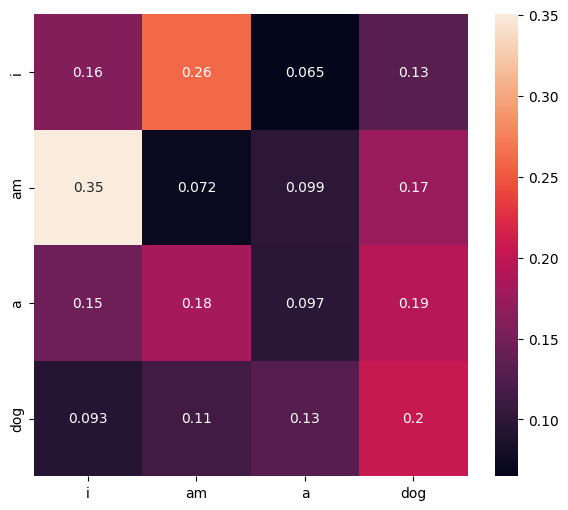

In [40]:
# avg attention weights across attention heads
attention = attention_matrix.mean(dim=1).squeeze(0)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# clip attention so it doesn't include the CLS and SEP tokns:
num_tokens = len(tokens) - 2 + 1
word_attention = attention[1:num_tokens, 1:num_tokens]
word_input_ids = tokens[1:num_tokens]

# plot
plt.figure(figsize=(7, 6))
sns.heatmap(word_attention, xticklabels=word_input_ids, yticklabels=word_input_ids, annot=True)

Notice that the highest relationship between words is given by the words "I" and "am" which makes sense since they are strongly related. The differences are small, but also bear in mind that this is very early stage in the attention mechanism, and there are 12 encoding blocks stacked togetehr as we saw above.